## The Model

Markov::k期の決定に1~k-1期までの決定を含まなくてもよい

割引現在価値の和の問題をσという関数の問題に置き換えても可ということが知られている

## Dynamic Programing

消費の選択は明日以降の最適化と今日の消費のトレードオフ

## A First Pass Implementation

In [13]:
Pkg.add("Grid")

INFO: Cloning cache of Grid from git://github.com/timholy/Grid.jl.git
INFO: Cloning cache of WoodburyMatrices from git://github.com/timholy/WoodburyMatrices.jl.git
INFO: Installing Grid v0.4.0
INFO: Installing WoodburyMatrices v0.1.5
INFO: Package database updated
INFO: METADATA is out-of-date — you may not have the latest version of Grid
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [16]:
Pkg.add("IJulia")
Pkg.add("Plots")
Pkg.add("Optim")
Pkg.add("Grid")
Pkg.add("Interpolations")
Pkg.add("QuantEcon")

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of IJulia
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Cloning cache of FixedSizeArrays from git://github.com/SimonDanisch/FixedSizeArrays.jl.git
INFO: Cloning cache of Measures from git://github.com/dcjones/Measures.jl.git
INFO: Cloning cache of Plots from git://github.com/tbreloff/Plots.jl.git
INFO: Cloning cache of RecipesBase from git://github.com/JuliaPlots/RecipesBase.jl.git
INFO: Installing FixedSizeArrays v0.2.2
INFO: Installing Measures v0.0.2
INFO: Installing Plots v0.7.5
INFO: Installing RecipesBase v0.0.6
INFO: Building Plots
INFO: Cannot find deps/plotly-latest.min.js... downloading latest version.
INFO: Package database updated
INFO: METADATA is out-of-date — you may not have the latest version of Plots
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the lat

In [2]:
println(readall("lin_interp2.jl"))

immutable lin_interp2
    grid::Array
    vals::Array
end

function Base.call(points::lin_interp2, x::Real)
    i = searchsortedlast(grid, x)
    if i == 0 || i == length(grid)
        return 0
    end
    x_i = points.grid[i]
    x_j = points.grid[i + 1]
    y_i = points.vals[i]
    y_j = points.vals[i + 1]
        
    y = y_i + (y_j - y_i) * ((x - x_i) / (x_j - x_i))
    return y
end

function Base.call{T<:Real}(points::lin_interp2, x::AbstractVector{T})
    n = length(x)
    out = Array(Float64, n)
    for t in 1:n
        out[t] = points(x[t])
    end
    return out
end


In [3]:
include("lin_interp2.jl")

call (generic function with 1179 methods)

In [32]:
#=
A first pass at solving the optimal growth problem via value function
iteration.  A more general version is provided in optgrowth.py.

@author : Spencer Lyon <spencer.lyon@nyu.edu>
          Victoria Gregory <victoria.gregory@nyu.edu>
=#

using Optim: optimize
using Grid: CoordInterpGrid, BCnan, InterpLinear
using Plots
pyplot()


## Primitives and grid
alpha = 0.65
bet = 0.95
grid_max = 2
grid_size = 150
grid = 1e-6:(grid_max-1e-6)/(grid_size-1):grid_max

## Exact solution
ab = alpha * bet
c1 = (log(1 - ab) + log(ab) * ab / (1 - ab)) / (1 - bet)
c2 = alpha / (1 - ab)
v_star(k) = c1 .+ c2 .* log(k)


function bellman_operator(grid, w)
    Aw = CoordInterpGrid(grid, w, BCnan, InterpLinear)

    Tw = zeros(w)

    for (i, k) in enumerate(grid)
        objective(c) = - log(c) - bet * Aw[k^alpha - c]
        res = optimize(objective, 1e-6, k^alpha)
        Tw[i] = - objective(res.minimum)
    end
    return Tw
end


function main(n::Int=35)
    w_init = 5 .* log(grid) .- 25  # An initial condition -- fairly arbitrary
    w = copy(w_init)

    ws = []
    colors = []
    for i=1:n
        w = bellman_operator(grid, w) # Twをwと読み直す
        push!(ws, w)
        push!(colors, RGBA(0, 0, 0, i/n))
    end

    p = plot(grid, w_init, color=:green, linewidth=2, alpha=0.6,
         label="initial condition")
    plot!(grid, ws, color=colors', label="", linewidth=2)
    plot!(grid, v_star(grid), color=:blue, linewidth=2, alpha=0.8,
         label="true value function")
    plot!(ylims=(-40, -20), xlims=(minimum(grid), maximum(grid)))

    return p
end

main (generic function with 2 methods)

[Plots.jl] Initializing backend: pyplot



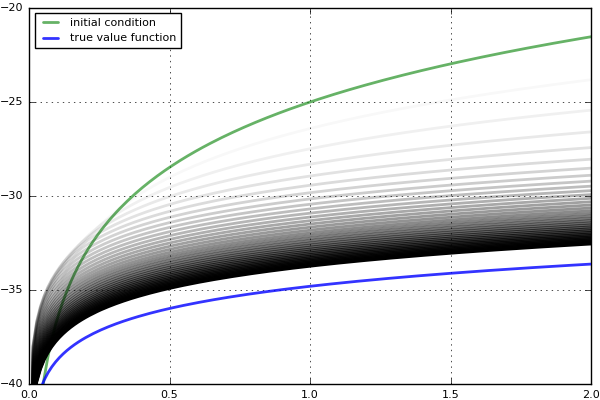

In [33]:
main()

In [43]:
#=
A first pass at solving the optimal growth problem via value function
iteration.  A more general version is provided in optgrowth.py.

@author : Spencer Lyon <spencer.lyon@nyu.edu>
          Victoria Gregory <victoria.gregory@nyu.edu>
=#

using Optim: optimize
using Plots
pyplot()


## Primitives and grid
alpha = 0.65
bet = 0.95
grid_max = 2
grid_size = 150
grid = 1e-6:(grid_max-1e-6)/(grid_size-1):grid_max

## Exact solution
ab = alpha * bet
c1 = (log(1 - ab) + log(ab) * ab / (1 - ab)) / (1 - bet)
c2 = alpha / (1 - ab)
v_star(k) = c1 .+ c2 .* log(k)


function bellman_operator(grid, w)
        Aw = lin_interp2(grid, w)

    Tw = zeros(w)

    for (i, k) in enumerate(grid)
        objective(c) = - log(c) - bet * Aw(k^alpha - c)
        res = optimize(objective, 1e-6, k^alpha)
        Tw[i] = - objective(res.minimum)
    end
    return Tw
end


function main(n::Int=35)
    w_init = 5 .* log(grid) .- 25  # An initial condition -- fairly arbitrary
    w = copy(w_init)

    ws = []
    colors = []
    for i=1:n
        w = bellman_operator(grid, w)
        push!(ws, w)
        push!(colors, RGBA(0, 0, 0, i/n))
    end

    p = plot(grid, w_init, color=:green, linewidth=2, alpha=0.6,
         label="initial condition")
    plot!(grid, ws, color=colors', label="", linewidth=2)
    plot!(grid, v_star(grid), color=:blue, linewidth=2, alpha=0.8,
         label="true value function")
    plot!(ylims=(-40, -20), xlims=(minimum(grid), maximum(grid)))

    return p
end

main (generic function with 2 methods)


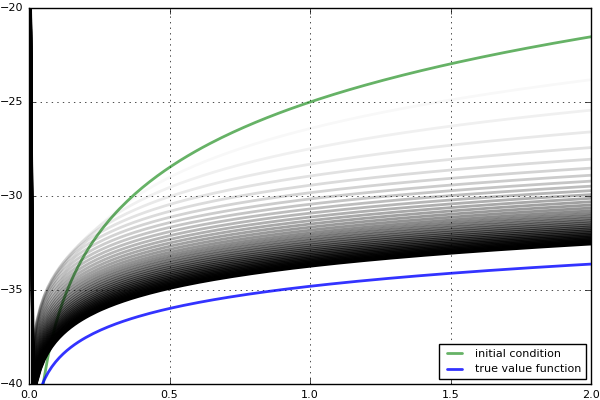

In [44]:
main()

In [23]:
?CoordInterpGrid

search: CoordInterpGrid



No documentation found.

**Summary:**

```julia
type Grid.CoordInterpGrid{T<:AbstractFloat,N,BC<:Grid.BoundaryCondition,IT<:Grid.InterpType,R} <: Grid.AbstractInterpGrid{T<:AbstractFloat,N,BC<:Grid.BoundaryCondition,IT<:Grid.InterpType}
```

**Fields:**

```julia
coord :: R
grid  :: Grid.InterpGrid{T<:AbstractFloat,N,BC<:Grid.BoundaryCondition,IT<:Grid.InterpType}
```


## Implemantation2

宿題：lin_interp2で実装

In [1]:
#=
Solving the optimal growth problem via value function iteration.

@author : Spencer Lyon <spencer.lyon@nyu.edu>

@date : 2014-07-05

References
----------

Simple port of the file quantecon.models.optgrowth

http://quant-econ.net/jl/dp_intro.html
=#

#=
    This type defines the primitives representing the growth model. The
    default values are

        f(k) = k**alpha, i.e, Cobb-Douglas production function
        u(c) = ln(c), i.e, log utility

    See the constructor below for details
=#
using Interpolations
using Optim

"""
Neoclassical growth model

##### Fields

- `f::Function` : Production function
- `bet::Real` : Discount factor in (0, 1)
- `u::Function` : Utility function
- `grid_max::Int` : Maximum for grid over savings values
- `grid_size::Int` : Number of points in grid for savings values
- `grid::LinSpace{Float64}` : The grid for savings values

"""
type GrowthModel
    f::Function
    bet::Float64
    u::Function
    grid_max::Int
    grid_size::Int
    grid::LinSpace{Float64}
end


default_f(k) = k^0.65
default_u(c) = log(c)

"""
Constructor of `GrowthModel`

##### Arguments

- `f::Function(k->k^0.65)` : Production function
- `bet::Real(0.95)` : Discount factor in (0, 1)
- `u::Function(log)` : Utility function
- `grid_max::Int(2)` : Maximum for grid over savings values
- `grid_size::Int(150)` : Number of points in grid for savings values

"""
function GrowthModel(f=default_f, bet=0.95, u=default_u, grid_max=2,
                     grid_size=150)
    grid = linspace(1e-6, grid_max, grid_size)
    return GrowthModel(f, bet, u, grid_max, grid_size, grid)
end

"""
Apply the Bellman operator for a given model and initial value.

##### Arguments

- `g::GrowthModel` : Instance of `GrowthModel`
- `w::Vector`: Current guess for the value function
- `out::Vector` : Storage for output.
- `;ret_policy::Bool(false)`: Toggles return of value or policy functions

##### Returns

None, `out` is updated in place. If `ret_policy == true` out is filled with the
policy function, otherwise the value function is stored in `out`.

"""
function bellman_operator!(g::GrowthModel, w::Vector, out::Vector;
                           ret_policy::Bool=false)
    # Apply linear interpolation to w
    Aw = lin_interp2(g.grid, w)

    for (i, k) in enumerate(g.grid)
        objective(c) = - g.u(c) - g.bet * Aw(g.f(k) - c)
        res = optimize(objective, 1e-6, g.f(k))
        c_star = res.minimum

        if ret_policy
            # set the policy equal to the optimal c
            out[i] = c_star
        else
            # set Tw[i] equal to max_c { u(c) + beta w(f(k_i) - c)}
            out[i] = - objective(c_star)
        end
    end

    return out
end

function bellman_operator(g::GrowthModel, w::Vector;
                          ret_policy::Bool=false)
    out = similar(w)
    bellman_operator!(g, w, out, ret_policy=ret_policy)
end

"""
Extract the greedy policy (policy function) of the model.

##### Arguments

- `g::GrowthModel` : Instance of `GrowthModel`
- `w::Vector`: Current guess for the value function
- `out::Vector` : Storage for output

##### Returns

None, `out` is updated in place to hold the policy function

"""
function get_greedy!(g::GrowthModel, w::Vector, out::Vector)
    bellman_operator!(g, w, out, ret_policy=true)
end

get_greedy(g::GrowthModel, w::Vector) = bellman_operator(g, w, ret_policy=true)

get_greedy (generic function with 1 method)

## Iteration

In [2]:
#=
Compute the fixed point of a given operator T, starting from
specified initial condition v.

@author : Spencer Lyon <spencer.lyon@nyu.edu>

@date: 2014-07-05

References
----------

http://quant-econ.net/jl/dp_intro.html
=#


"""
Repeatedly apply a function to search for a fixed point

Approximates `T^∞ v`, where `T` is an operator (function) and `v` is an initial
guess for the fixed point. Will terminate either when `T^{k+1}(v) - T^k v <
err_tol` or `max_iter` iterations has been exceeded.

Provided that `T` is a contraction mapping or similar,  the return value will
be an approximation to the fixed point of `T`.

##### Arguments

* `T`: A function representing the operator `T`
* `v::TV`: The initial condition. An object of type `TV`
* `;err_tol(1e-3)`: Stopping tolerance for iterations
* `;max_iter(50)`: Maximum number of iterations
* `;verbose(2)`: Level of feedback (0 for no output, 1 for warnings only, 2
        for warning and convergence messages during iteration)
* `;print_skip(10)` : if `verbose == 2`, how many iterations to apply between
        print messages

##### Returns
---

* '::TV': The fixed point of the operator `T`. Has type `TV`

##### Example

```julia
using QuantEcon
T(x, μ) = 4.0 * μ * x * (1.0 - x)
x_star = compute_fixed_point(x->T(x, 0.3), 0.4)  # (4μ - 1)/(4μ)
```

"""
function compute_fixed_point{TV}(T::Function, 
                                v::TV; 
                                err_tol=1e-4,
                                max_iter=100, 
                                verbose=2, 
                                print_skip=10)

    if !(verbose in (0, 1, 2))
        throw(ArgumentError("verbose should be 0, 1 or 2"))
    end

    iterate = 0
    err = err_tol + 1
    while iterate < max_iter && err > err_tol
        new_v = T(v)::TV
        iterate += 1
        err = Base.maxabs(new_v - v)
        if verbose == 2
            if iterate % print_skip == 0
                println("Compute iterate $iterate with error $err")
            end
        end
        v = new_v
    end

    if verbose >= 1
        if iterate == max_iter
            warn("max_iter attained in compute_fixed_point")
        elseif verbose == 2
            println("Converged in $iterate steps")
        end
    end

    return v
end

compute_fixed_point (generic function with 1 method)

In [4]:
## Primitives and grid
alpha = 0.65
bet = 0.95
grid_max = 2
grid_size = 150
grid = 1e-6:(grid_max-1e-6)/(grid_size-1):grid_max

## Exact solution
ab = alpha * bet
c1 = (log(1 - ab) + log(ab) * ab / (1 - ab)) / (1 - bet)
c2 = alpha / (1 - ab)
v_star(k) = c1 .+ c2 .* log(k)

function main(n::Int=35)
    w_init = 5 .* log(grid) .- 25  # An initial condition -- fairly arbitrary
    w = copy(w_init)

    ws = []
    colors = []
    for i=1:n
        w = bellman_operator(grid, w)
        push!(ws, w)
        push!(colors, RGBA(0, 0, 0, i/n))
    end

    p = plot(grid, w_init, color=:green, linewidth=2, alpha=0.6,
         label="initial condition")
    plot!(grid, ws, color=colors', label="", linewidth=2)
    plot!(grid, v_star(grid), color=:blue, linewidth=2, alpha=0.8,
         label="true value function")
    plot!(ylims=(-40, -20), xlims=(minimum(grid), maximum(grid)))

    return p
end

main (generic function with 2 methods)

In [5]:
main()

LoadError: LoadError: MethodError: `bellman_operator` has no method matching bellman_operator(::FloatRange{Float64}, ::Array{Float64,1})
Closest candidates are:
  bellman_operator(!Matched::GrowthModel, ::Array{T,1})
while loading In[5], in expression starting on line 1

## Iteration

In [19]:
#=
Compute the fixed point of a given operator T, starting from
specified initial condition v.

@author : Spencer Lyon <spencer.lyon@nyu.edu>

@date: 2014-07-05

References
----------

http://quant-econ.net/jl/dp_intro.html
=#


"""
Repeatedly apply a function to search for a fixed point

Approximates `T^∞ v`, where `T` is an operator (function) and `v` is an initial
guess for the fixed point. Will terminate either when `T^{k+1}(v) - T^k v <
err_tol` or `max_iter` iterations has been exceeded.

Provided that `T` is a contraction mapping or similar,  the return value will
be an approximation to the fixed point of `T`.

##### Arguments

* `T`: A function representing the operator `T`
* `v::TV`: The initial condition. An object of type `TV`
* `;err_tol(1e-3)`: Stopping tolerance for iterations
* `;max_iter(50)`: Maximum number of iterations
* `;verbose(true)`: Whether or not to print status updates to the user
* `;print_skip(10)` : if `verbose` is true, how many iterations to apply between
  print messages

##### Returns
---

* '::TV': The fixed point of the operator `T`. Has type `TV`

##### Example

```julia
using QuantEcon
T(x, μ) = 4.0 * μ * x * (1.0 - x)
x_star = compute_fixed_point(x->T(x, 0.3), 0.4)  # (4μ - 1)/(4μ)
```

"""
function compute_fixed_point{TV}(T::Function, v::TV; err_tol=1e-3,
                                 max_iter=50, verbose=true, print_skip=10)
    iterate = 0
    err = err_tol + 1
    while iterate < max_iter && err > err_tol
        new_v = T(v)::TV
        iterate += 1
        err = Base.maxabs(new_v - v)
        if verbose
            if iterate % print_skip == 0
                println("Compute iterate $iterate with error $err")
            end
        end
        v = new_v
    end

    if iterate < max_iter && verbose
        println("Converged in $iterate steps")
    elseif iterate == max_iter
        warn("max_iter exceeded in compute_fixed_point")
    end

    return v
end

compute_fixed_point (generic function with 1 method)

In [9]:
?enumerate

search: enumerate Enumerate



```
enumerate(iter)
```

An iterator that yields `(i, x)` where `i` is an index starting at 1, and `x` is the `i`th value from the given iterator. It's useful when you need not only the values `x` over which you are iterating, but also the index `i` of the iterations.

```jldoctest
julia> a = ["a", "b", "c"];

julia> for (index, value) in enumerate(a)
           println("$index $value")
       end
1 a
2 b
3 c
```
